In [1]:
#checking we are working on the right virtual environment

In [2]:
import sys
sys.executable
#!pip3 freeze > requirements.txt
#!python --version

'/Users/federicojacopobaldoni/Documents/LUISS/machine_learning/pino_env/bin/python3'

In [3]:
#importing packages

In [4]:
import numpy as np
import pandas as pd

from ydata_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations
from scipy.stats import spearmanr

from sklearn.model_selection import StratifiedShuffleSplit
from math import log2

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PowerTransformer
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import datetime

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

from yellowbrick.regressor import PredictionError, ResidualsPlot

let's define a few funcion that will help us later

In [5]:
def visualizer():
    viz = PredictionError(model, bestfit=False, alpha=0.2) #it gives problems with bestfit=True
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()
    viz = ResidualsPlot(model, test_alpha=0.1) #, hist=False, qqplot=True
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()

In [6]:
def metrics():
    print('R2:')
    print('train', r2_score(y_train, model.predict(X_train)))
    print('test:', r2_score(y_test, model.predict(X_test)))
    print('\n')
    print('RMSE')
    print('train', np.sqrt(mean_squared_error(y_train, model.predict(X_train))))
    print('test:', np.sqrt(mean_squared_error(y_test, model.predict(X_test))))
    print('\n')
    print('R2:')
    print('train', mean_absolute_percentage_error(y_train, model.predict(X_train))) #Note here that the output is not a percentage in the range [0, 100] and a value of 100 does not mean 100% but 1e2.
    print('test:', mean_absolute_percentage_error(y_test, model.predict(X_test))) #Note here that the output is not a percentage in the range [0, 100] and a value of 100 does not mean 100% but 1e2.
    print('\n')

# EDA

importing dataset

In [7]:
df = pd.read_csv('./Project datasets-20230327/flight_dataset.csv', index_col=0)
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


resetting index, just to be sure

In [8]:
df.reset_index(inplace=True, drop=True)

In [9]:
#profile = ProfileReport(df, title="FLIGHTS - Pandas Profiling Report", explorative=True)
#profile.to_file("flights.html")

checking for nans

In [10]:
df.shape

(300153, 11)

In [11]:
df.isna().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

checking for duplicates

In [12]:
df.duplicated().sum()

0

In [13]:
df.describe()

,duration,days_left,price
count,300153.000000,300153.000000,300153.000000
mean,12.221021,26.004751,20889.660523
std,7.191997,13.561004,22697.767366
min,0.830000,1.000000,1105.000000
25%,6.830000,15.000000,4783.000000
50%,11.250000,26.000000,7425.000000
75%,16.170000,38.000000,42521.000000
max,49.830000,49.000000,123071.000000


In [14]:
########
########

## PRICE

looking at price distribution

Text(0.5, 1.0, 'PRICE HISTOGRAM')

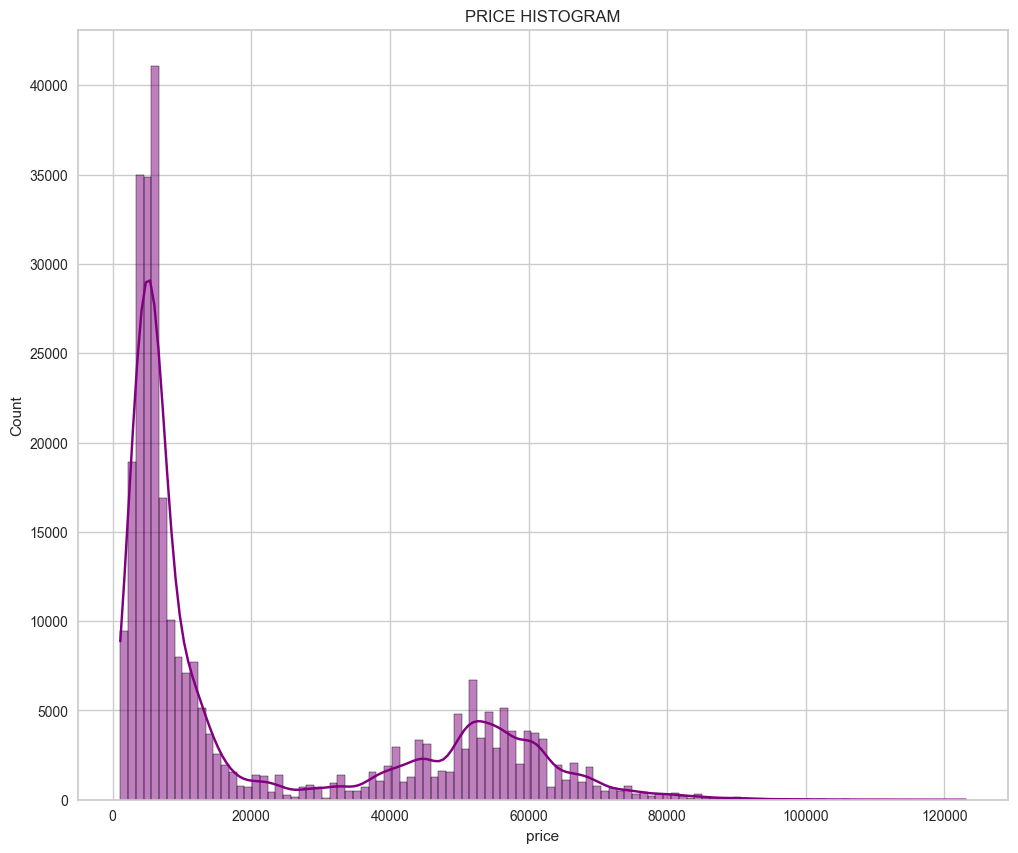

In [15]:
fig, axs = plt.subplots(figsize=(12,10))
sns.histplot(data=df, x='price', kde=True, color='purple')
plt.title('PRICE HISTOGRAM')

price seems to be pretty skewed

we'll probably have to work on it later

Text(0.5, 1.0, 'PRICE BOXPLOT')

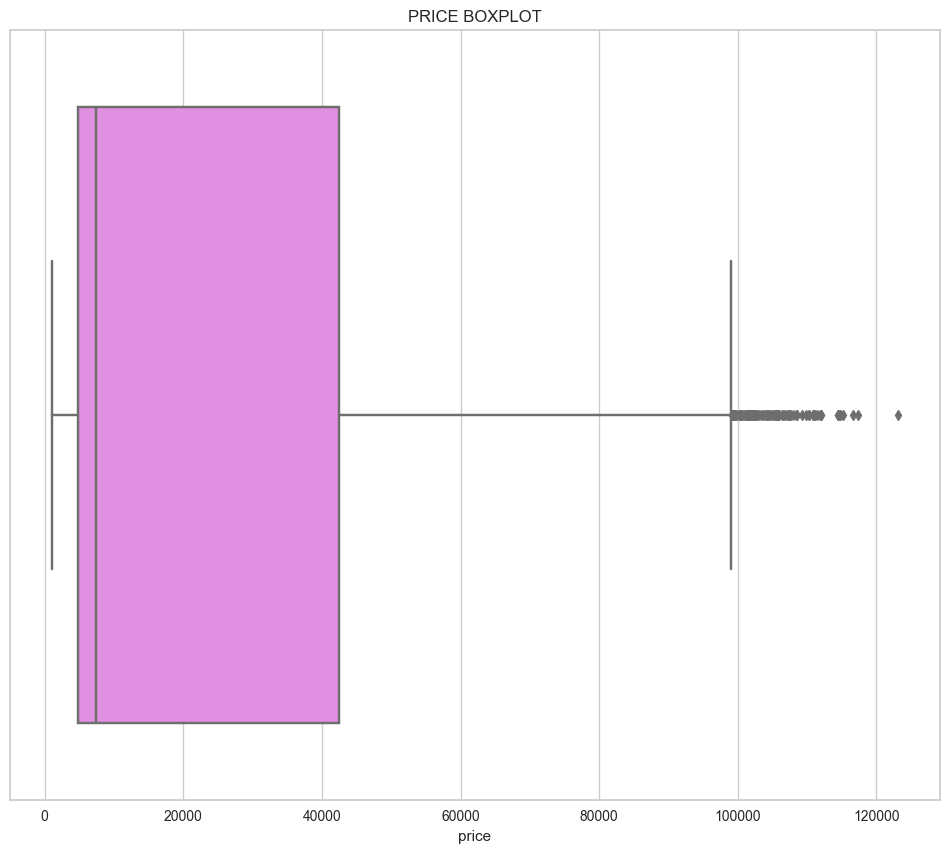

In [16]:
fig, axs = plt.subplots(figsize=(12,10))
sns.boxplot(data=df, x='price', color='violet')
plt.title('PRICE BOXPLOT')

In [17]:
#########
########

### CITIES

price boxplots on source and destionation cities

[Text(0.5, 1.0, 'BOXPLOT PRICE - DESTINATION CITY')]

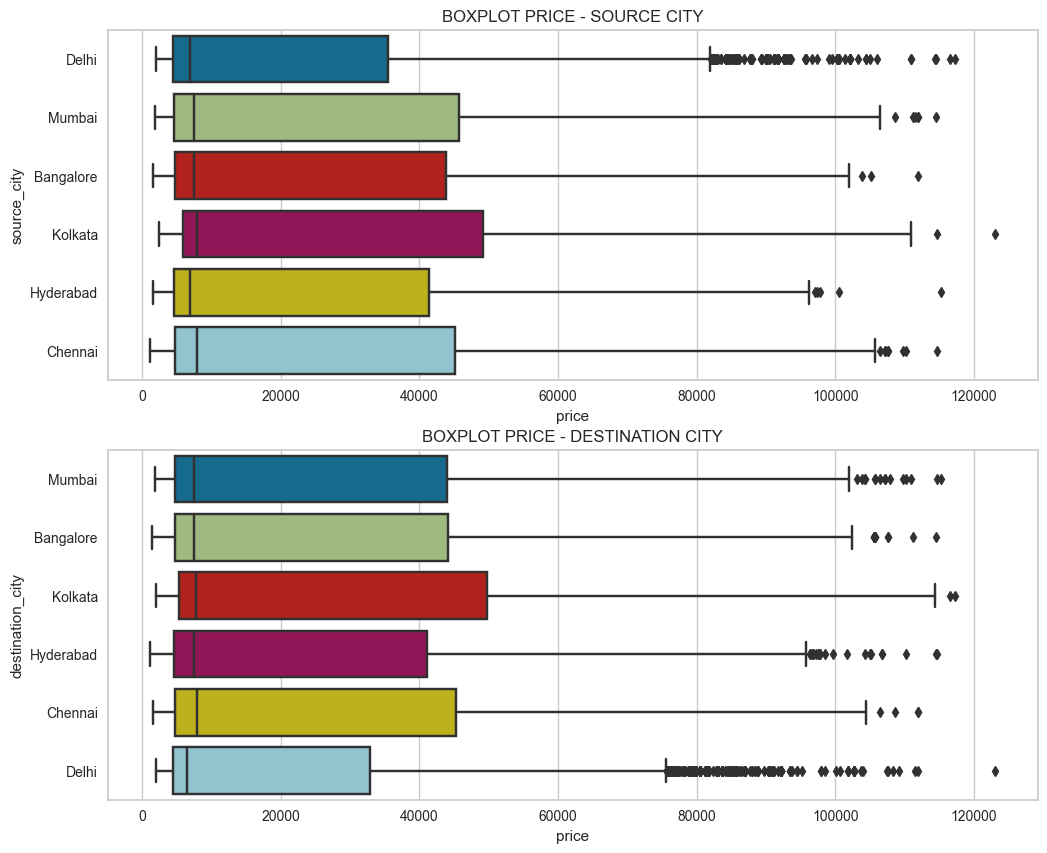

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(12,10))

g1 = sns.boxplot(data=df, x='price', y='source_city', ax=axs[0])
g1.set(title = 'BOXPLOT PRICE - SOURCE CITY')

g2 = sns.boxplot(data=df, x='price', y='destination_city', ax=axs[1])
g2.set(title = 'BOXPLOT PRICE - DESTINATION CITY')

[Text(0.5, 1.0, 'COUNTPLOT & KDES PRICE - DESTINATION CITY')]

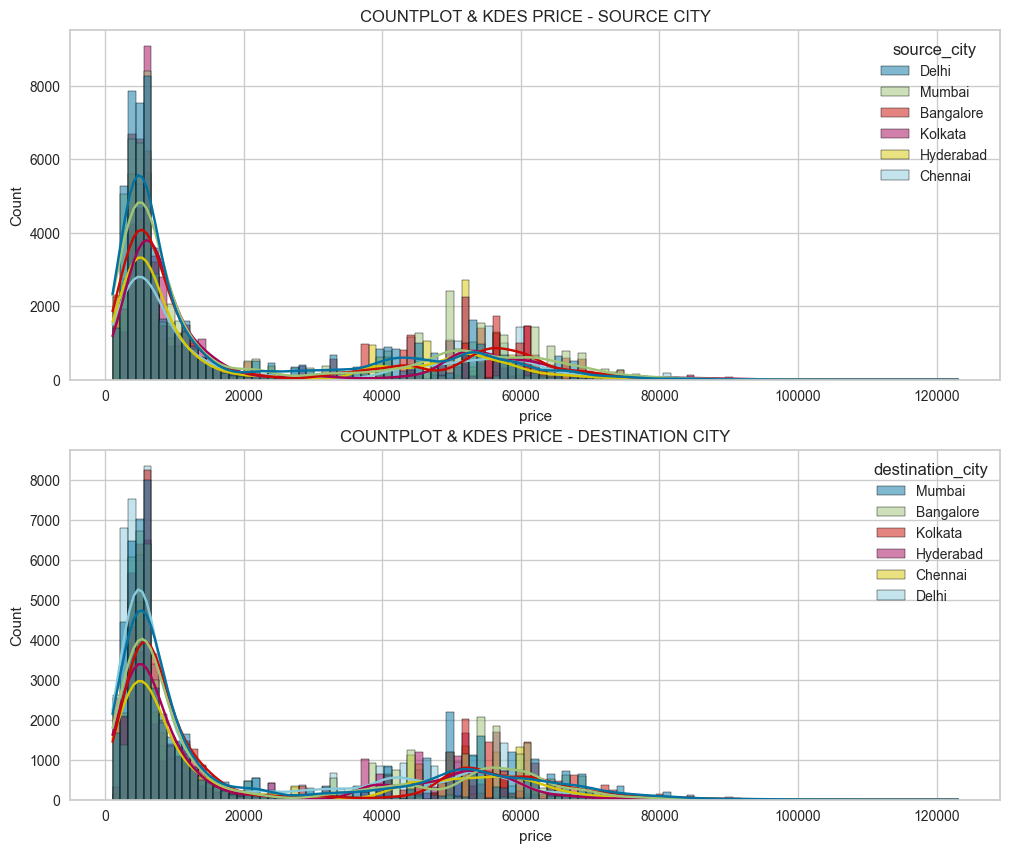

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(12,10))

g1 = sns.histplot(data=df, x='price', hue='source_city', kde=True, ax=axs[0])
g1.set(title = 'COUNTPLOT & KDES PRICE - SOURCE CITY')

g2 = sns.histplot(data=df, x='price', hue='destination_city', kde=True, ax=axs[1])
g2.set(title = 'COUNTPLOT & KDES PRICE - DESTINATION CITY')

Indipendently from source or destination city, more economy flights are sold than business flights

In [20]:
city_cross = pd.crosstab(df['source_city'], df['destination_city'])
city_cross

destination_city,Bangalore,Chennai,Delhi,Hyderabad,Kolkata,Mumbai
source_city,,,,,,
Bangalore,0,6410,13756,8928,10028,12939
Chennai,6493,0,9783,6103,6983,9338
Delhi,14012,10780,0,9328,11934,15289
Hyderabad,7854,6395,8506,0,7987,10064
Kolkata,9824,6653,10506,7897,0,11467
Mumbai,12885,10130,14809,10470,12602,0


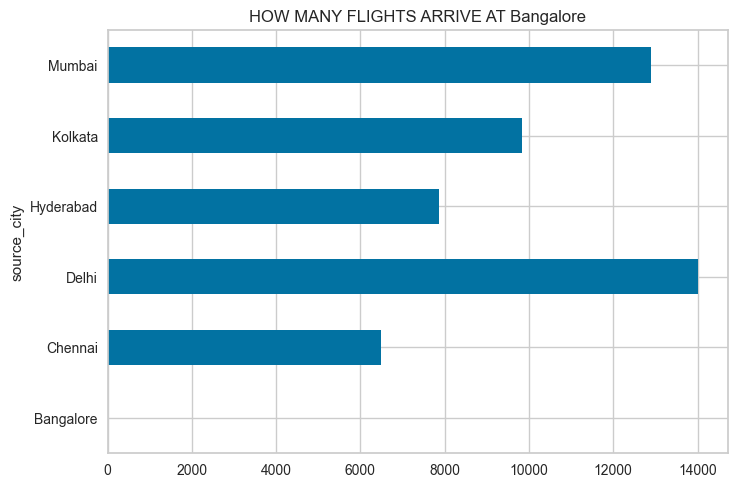

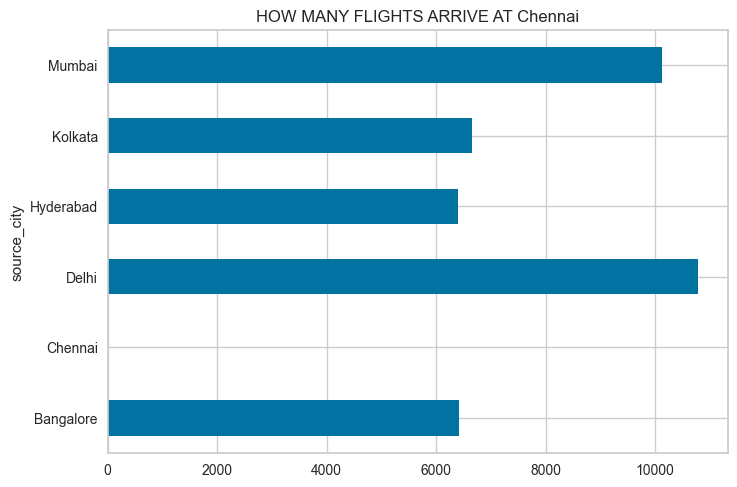

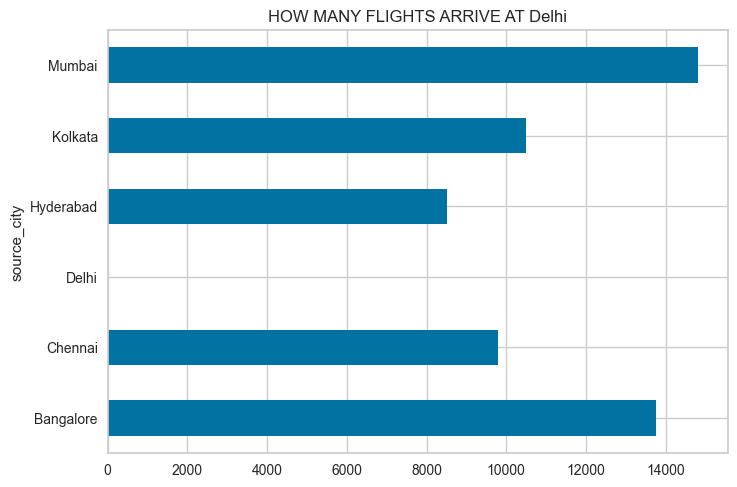

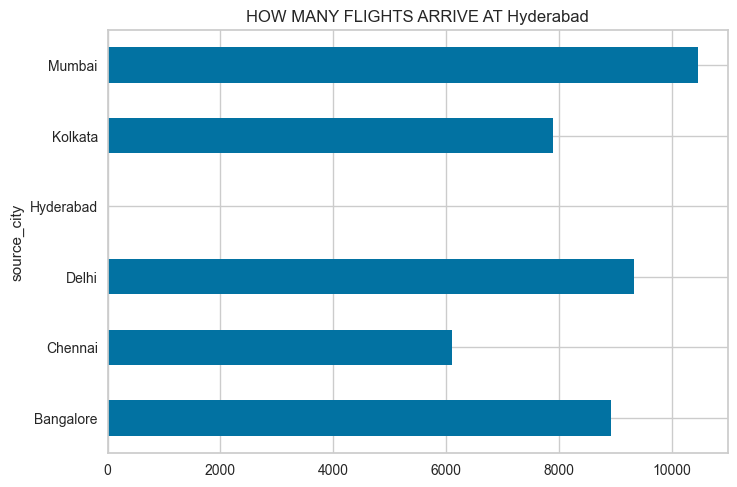

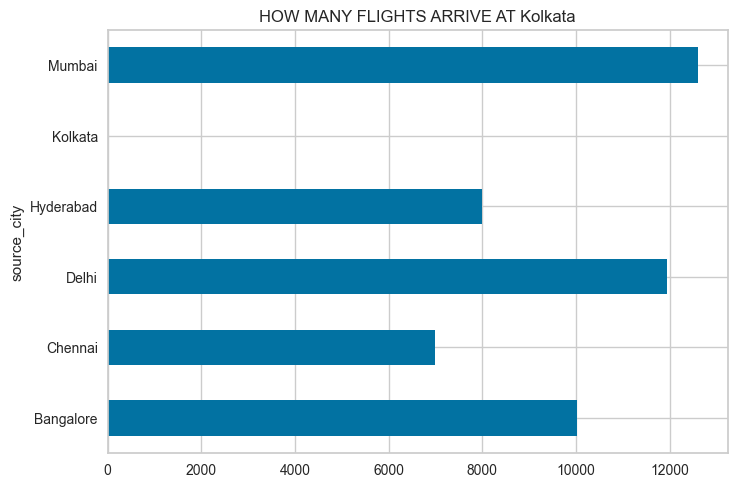

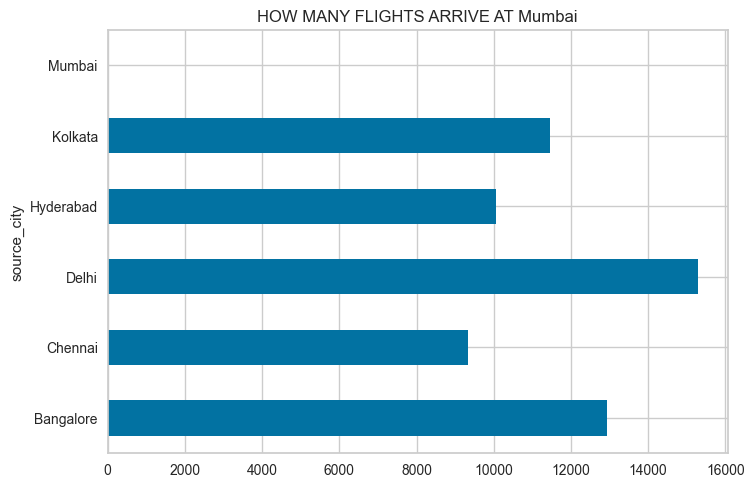

In [21]:
for i in city_cross.columns:
    city_cross[f'{i}'].plot(kind='barh')
    #plt.grid()
    plt.title(f'HOW MANY FLIGHTS ARRIVE AT {i}')
    plt.show()

In [22]:
########
########

### STOPS

price boxplots on the number of stops made

Text(0.5, 1.0, 'BOXPLOT PRICE - STOPS')

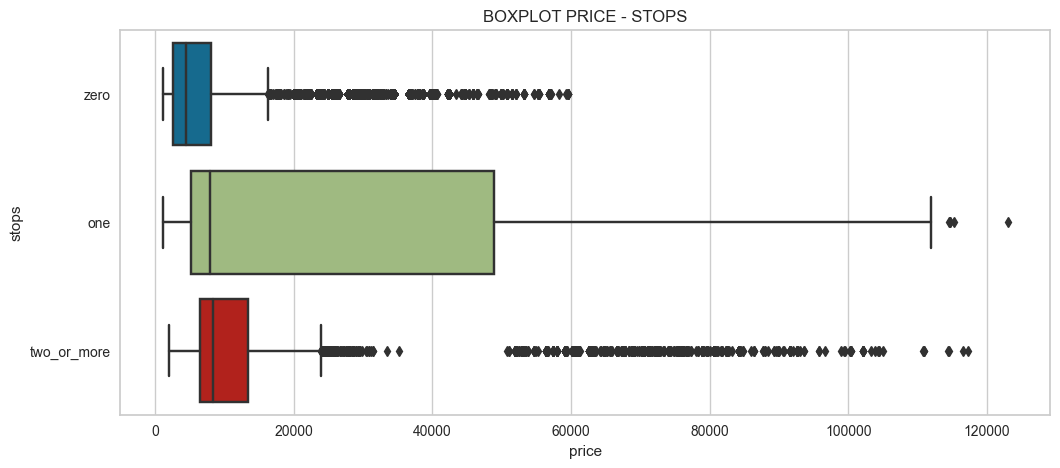

In [23]:
plt.subplots(figsize=(12,5))
sns.boxplot(data=df, x='price', y='stops')
plt.title('BOXPLOT PRICE - STOPS')

interestingly zero stops flights tend to be the more economic ones, this may be due to the fact that they make smaller voyages


two or more stops have a lot of outliers, may that be last minute flights?

Text(0.5, 1.0, 'COUNTPLOT & KDES PRICE - STOPS')

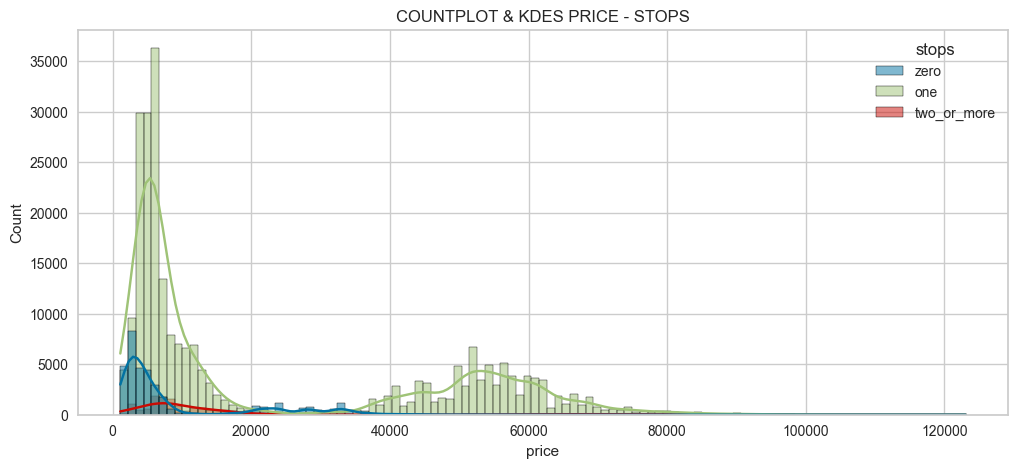

In [24]:
plt.subplots(figsize=(12,5))
sns.histplot(data=df, x='price', hue='stops', kde=True)
plt.title('COUNTPLOT & KDES PRICE - STOPS')

two or more stops flights are the least sold.

one stop flights sell a lot more than the other two categories and sell for both economy and business trips.

zero stops flights sell mostly economy flights

In [25]:
stops_cross = pd.crosstab(df['destination_city'], df['stops'])
stops_cross

stops,one,two_or_more,zero
destination_city,,,
Bangalore,42516,2674,5878
Chennai,33316,3239,3813
Delhi,46536,785,10039
Hyderabad,36578,2064,4084
Kolkata,42177,3195,4162
Mumbai,49740,1329,8028


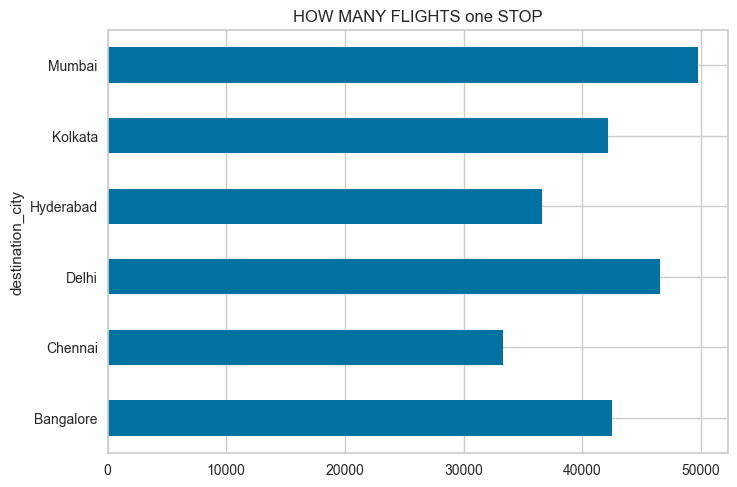

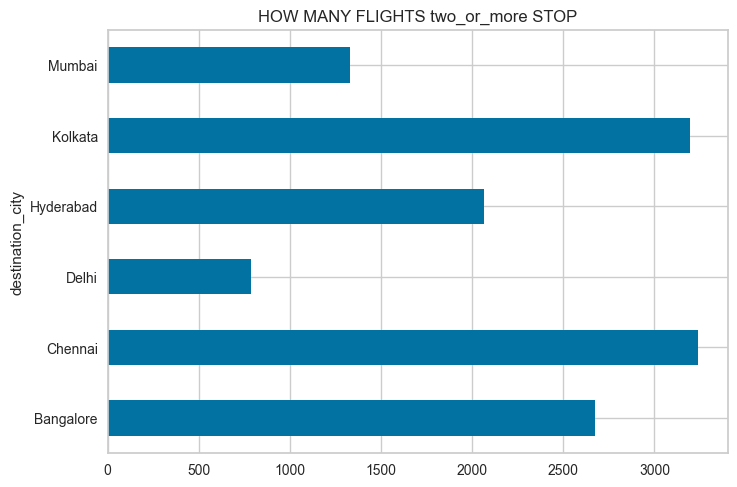

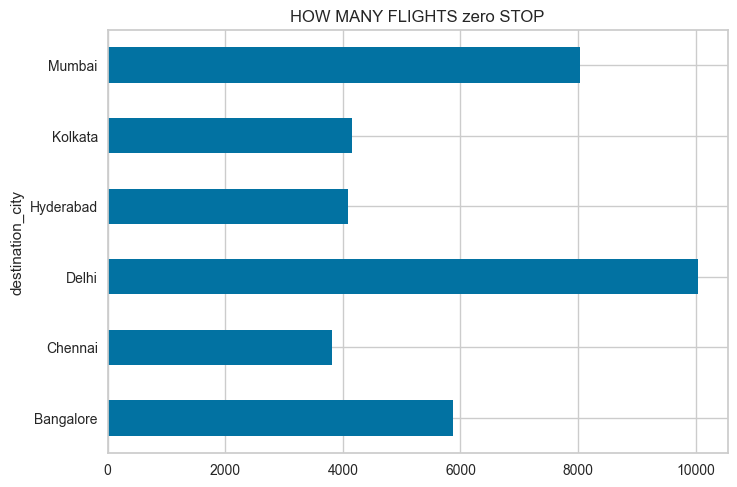

In [26]:
for i in stops_cross.columns:
    stops_cross[f'{i}'].plot(kind='barh')
    #plt.grid()
    plt.title(f'HOW MANY FLIGHTS {i} STOP')
    plt.show()

Dheli doen't work a lot with two or more stops flights, but works a lot more than the others with zero stop fligths

In [27]:
#########
#########

### ARRIVAL TIME

price boxplots on the arrival time

Text(0.5, 1.0, 'BOXPLOT PRICE - ARRIVAL TIME')

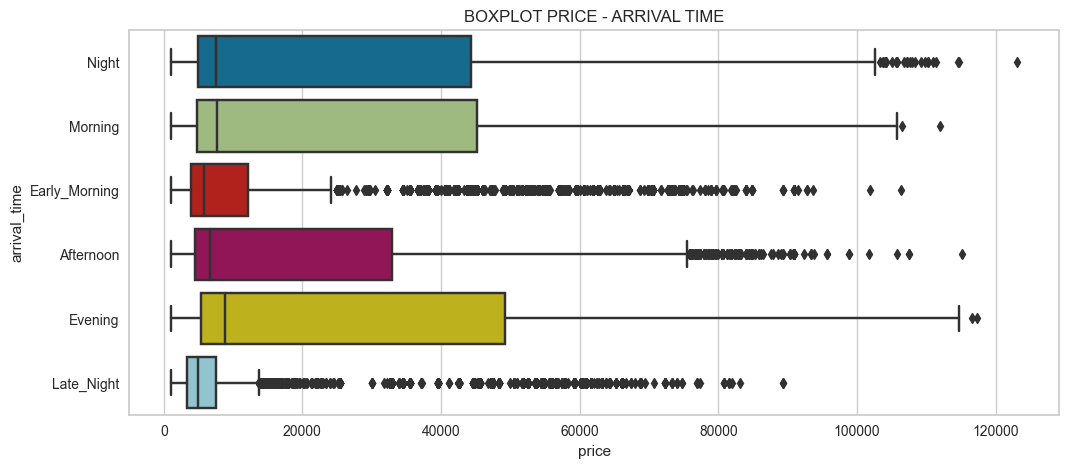

In [28]:
plt.subplots(figsize=(12,5))
sns.boxplot(data=df, x='price', y='arrival_time')
plt.title('BOXPLOT PRICE - ARRIVAL TIME')

as expected the most economic flights are the one that arrive at destination in the late night or early in the morining

also afternoon flights is reasonable that are a little cheaper than the reaming arrival time

Text(0.5, 1.0, 'COUNTPLOT & KDES PRICE - ARRIVAL TIME')

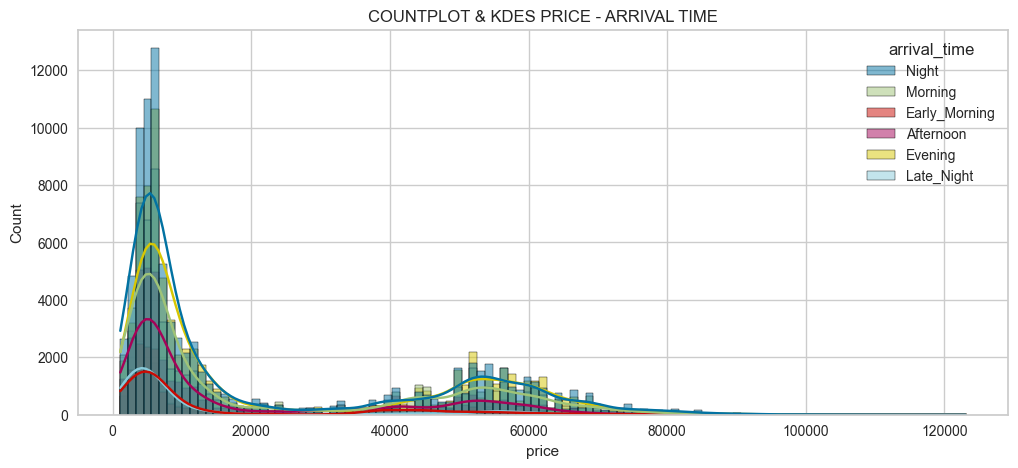

In [29]:
plt.subplots(figsize=(12,5))
sns.histplot(data=df, x='price', hue='arrival_time', kde=True)
plt.title('COUNTPLOT & KDES PRICE - ARRIVAL TIME')

most of tickets is sold at a low price. Tickets indeferently from the arrival_time, except for early_morning flights, seems to have a little peak at 40.000-60.000 price. That's probably due to business flights sales, while the first peak is for economy sales

In [30]:
arr_cross = pd.crosstab(df['destination_city'], df['arrival_time'])
arr_cross

arrival_time,Afternoon,Early_Morning,Evening,Late_Night,Morning,Night
destination_city,,,,,,
Bangalore,4827,1823,13937,3176,11246,16059
Chennai,2731,3481,9318,975,10680,13183
Delhi,10206,536,13940,6296,10338,16044
Hyderabad,6318,3822,10498,555,7511,14022
Kolkata,5540,2377,17917,1230,11982,10488
Mumbai,8517,3378,12713,1769,10978,21742


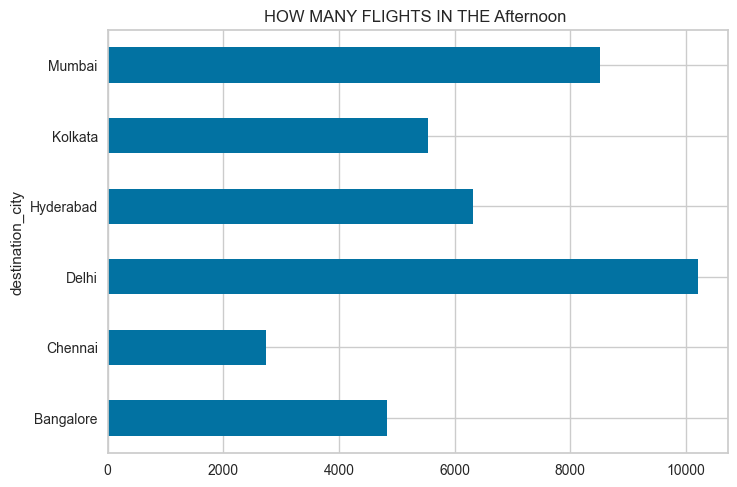

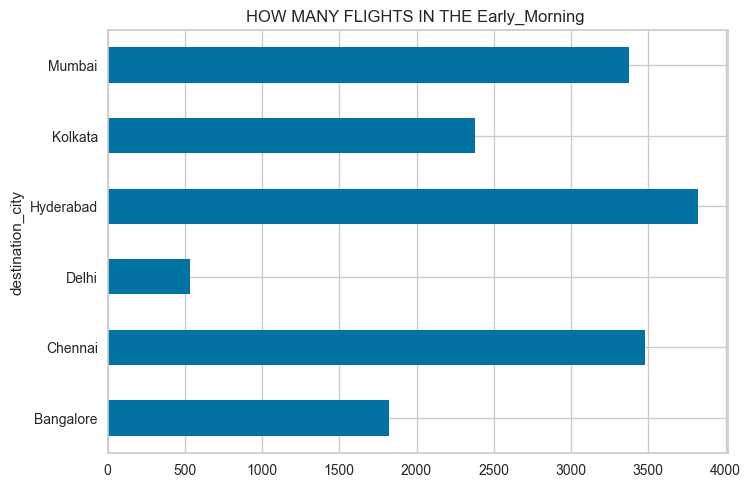

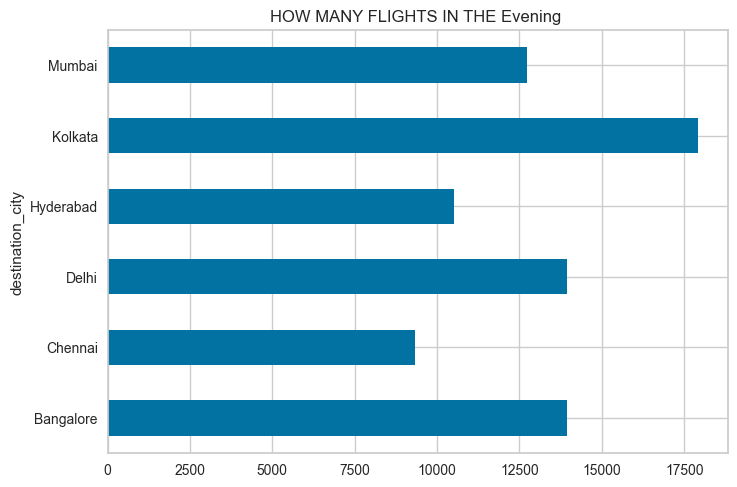

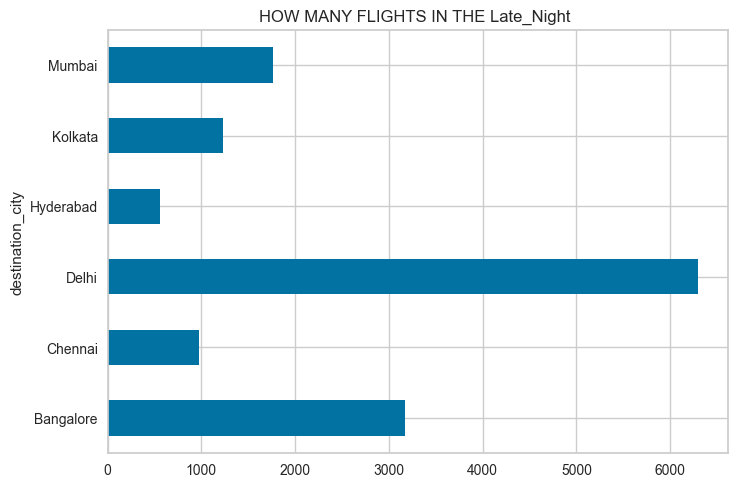

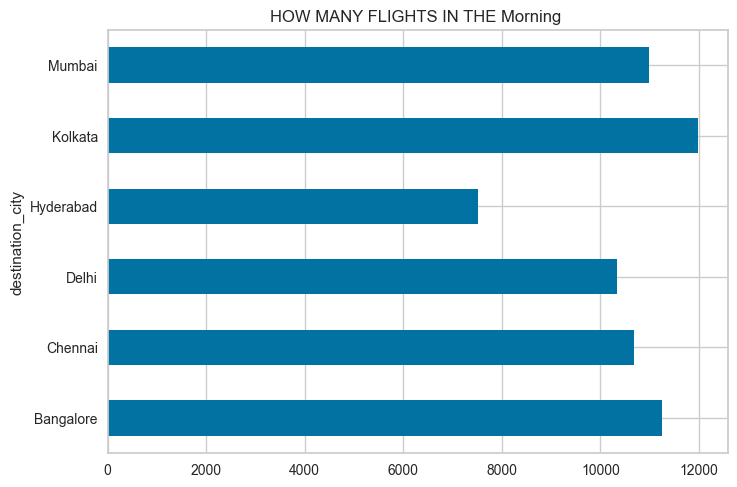

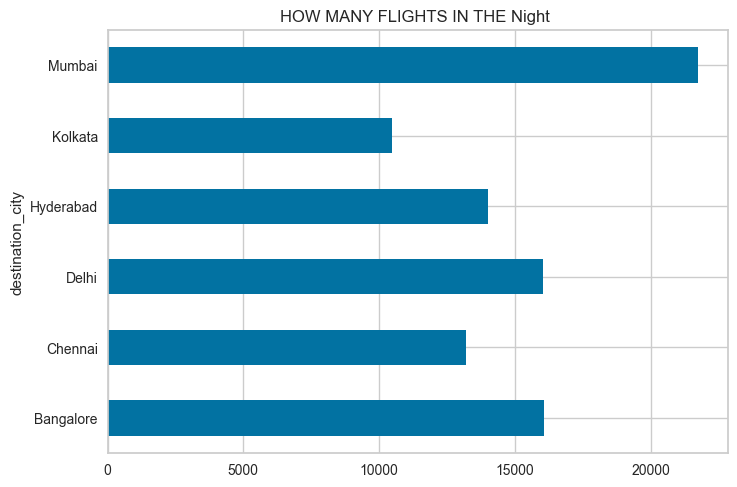

In [31]:
for i in arr_cross.columns:
    arr_cross[f'{i}'].plot(kind='barh')
    #plt.grid()
    plt.title(f'HOW MANY FLIGHTS IN THE {i} ')
    plt.show()

it's interesting to notice that Dheli seems to work a lot in the Late_Night, but pretty much nothing in the Early_Morning

In [32]:
########
########

### CLASS

price boxplots on class

Text(0.5, 1.0, 'BOXPLOT PRICE - CLASS')

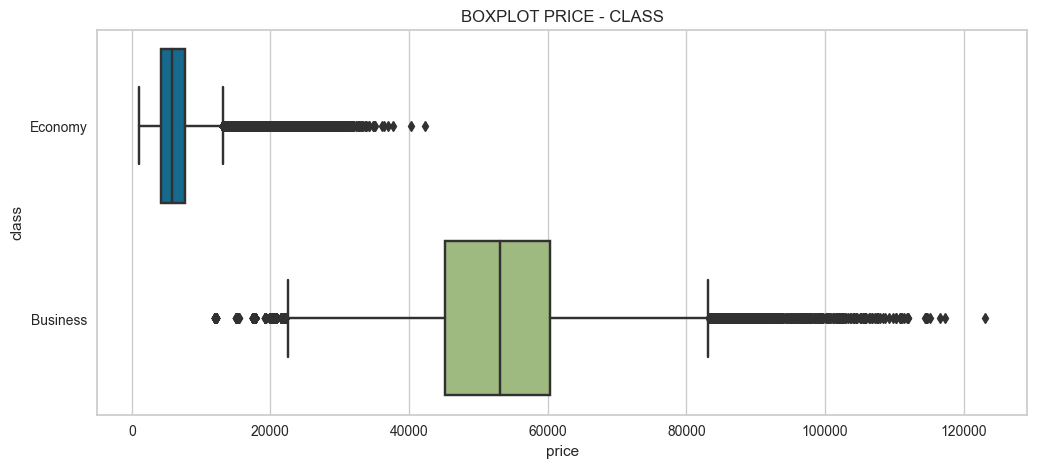

In [33]:
plt.subplots(figsize=(12,5))
sns.boxplot(data=df, x='price', y='class')
plt.title('BOXPLOT PRICE - CLASS')

well.. as exepcted economy flights are cheaper

plotting countplot and kdes for economy price and business price

Text(0.5, 1.0, 'COUNTPLOT & KDES PRICE - STOPS')

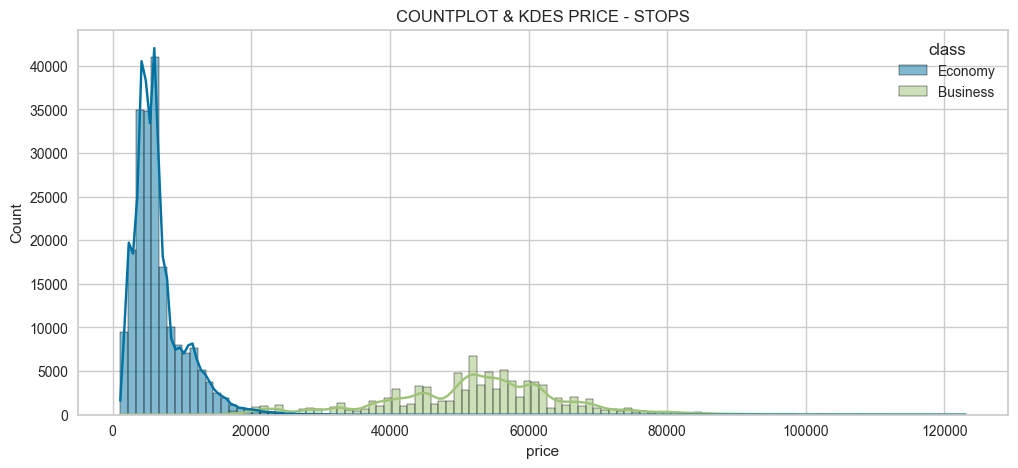

In [34]:
plt.subplots(figsize=(12,5))
sns.histplot(data=df, x='price', hue='class', kde=True)
plt.title('COUNTPLOT & KDES PRICE - STOPS')

business pricess seems to be pretty much Normally distriubuted, but we can't say the same for economy prices

In [35]:
########
########

### DURATION

price - duration scatterplot

Text(0.5, 1.0, 'SCATTERPLOT PRICE - DURATION')

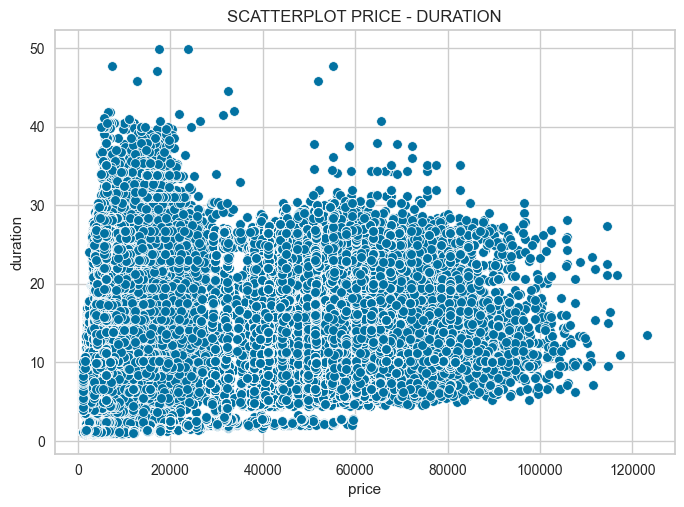

In [36]:
sns.scatterplot(data=df, x='price', y='duration')
plt.title('SCATTERPLOT PRICE - DURATION')

paradoxaly longer duration flights are not the more expensive

In [37]:
#########
#########

## CORRELATION

correlation matrix

/var/folders/fm/x5zqnyj163g5fgggdb9tcnbc0000gn/T/ipykernel_2504/3656167835.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap="coolwarm")


<AxesSubplot: >

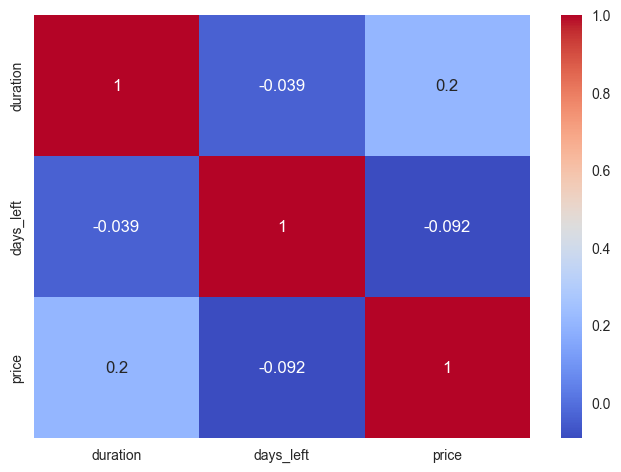

In [38]:
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")

linear correlation is really low, so we expect that linear models won't perform that good.

we still try to predict with a linear model, and then we will compare it's error metric with the one of the other models

Spearman correlation coefficient for categorical variables

In [39]:
df_cat = df.copy()
for i in df_cat.columns:
    if df_cat[i].dtypes == 'int64' or df_cat[i].dtypes == 'float64':       
           df_cat = df_cat.drop(i, axis=1)
            
for i in df_cat.columns:
    df_cat[i] = df_cat[i].astype('category')

print('Spearman correlation coefficient: \n')
for col1, col2 in combinations(df_cat.columns, 2):
    correlation, p_value = spearmanr(df_cat[col1].cat.codes, df_cat[col2].cat.codes)
    print(col1, '-', col2, ': ', correlation)

Spearman correlation coefficient: 

airline - flight :  0.7034151104009911
airline - source_city :  -0.02735238546003054
airline - departure_time :  0.05421849551088196
airline - stops :  -0.03891205058598072
airline - arrival_time :  0.0355373013881484
airline - destination_city :  -0.0298873183638078
airline - class :  -0.18756793050928966
flight - source_city :  0.026230830567236466
flight - departure_time :  0.07594613693939253
flight - stops :  -0.09626058154289178
flight - arrival_time :  0.04591479336881819
flight - destination_city :  -0.06203597994143653
flight - class :  -0.252726492158629
source_city - departure_time :  -0.009032857532994504
source_city - stops :  0.0019511299626186868
source_city - arrival_time :  0.043530711979684736
source_city - destination_city :  -0.22347900963637238
source_city - class :  -0.0003281686837138966
departure_time - stops :  -0.01372628408854511
departure_time - arrival_time :  -0.05672463417188827
departure_time - destination_city :  0.00

In [40]:
#############
#############

# PRE-PROCESSING

we've already seen that there are non missing values and no duplicates, so we will look for outliers

## OUTLIER DETECTION WITH BOXPLOTS

Text(0.5, 1.0, 'PRICE BOXPLOT')

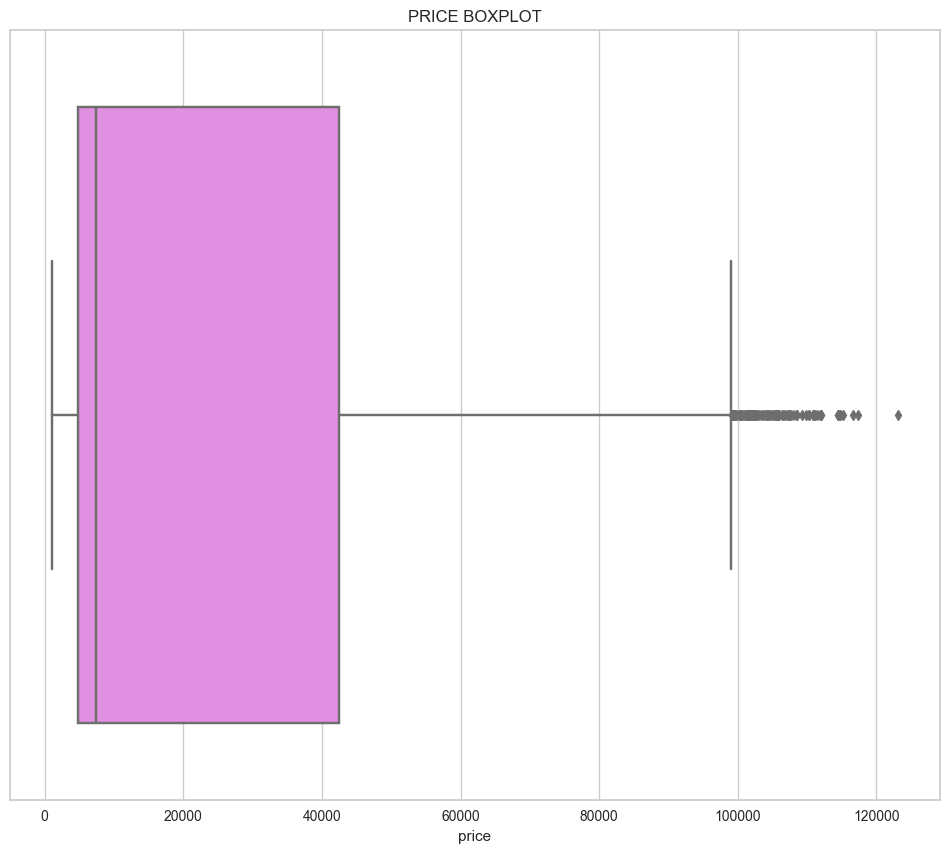

In [41]:
fig, axs = plt.subplots(figsize=(12,10))
sns.boxplot(data=df, x='price', color='violet')
plt.title('PRICE BOXPLOT')

calculating interquantile range and conisdering outlier each observation that is over the treshold of +/-1.5*IQR

In [42]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

out = df[(df['price'] < Q1 - 1.5*IQR) | (df['price'] > Q3 + 1.5*IQR)]
print(len(out), 'outliers were found')

123 outliers were found


removing outliers from the original df and definig a new one

In [43]:
not_out = df.loc[~df.index.isin(out.index)]
not_out.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [44]:
#subsets make sense
not_out.shape[0]+out.shape[0] == df.shape[0]

True

Text(0.5, 1.0, 'PRICE BOXPLOT - NO OUTLIERS')

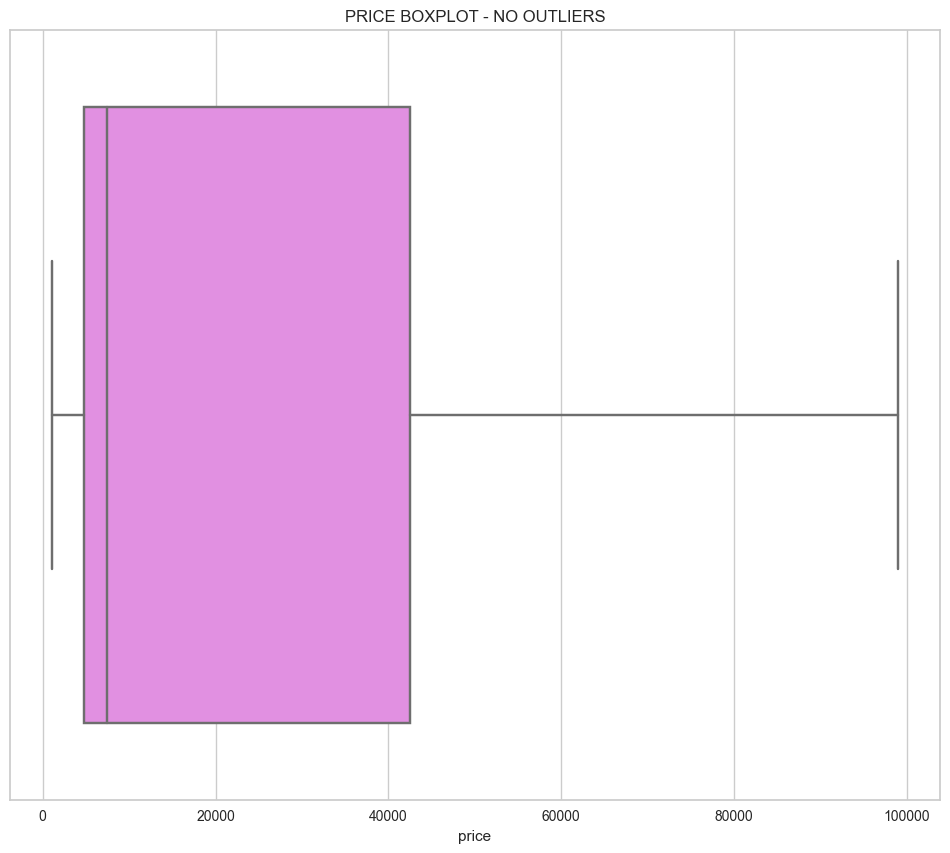

In [45]:
fig, axs = plt.subplots(figsize=(12,10))
sns.boxplot(data=not_out, x='price', color='violet')
plt.title('PRICE BOXPLOT - NO OUTLIERS')

we subscribe the original df with our new df without outliers

In [46]:
df = not_out.copy()

In [47]:
##########
##########

## STRTIFIED TRAIN-TEST SPLIT

In [48]:
#code was inspired by asking to chatgpt:"do you how can i make a stratified train test split for a regression problem?"

now we look for the right number of bins to make our stratified train-test split

In [49]:
#aggiungere testi ai grafici

<AxesSubplot: xlabel='price', ylabel='Count'>

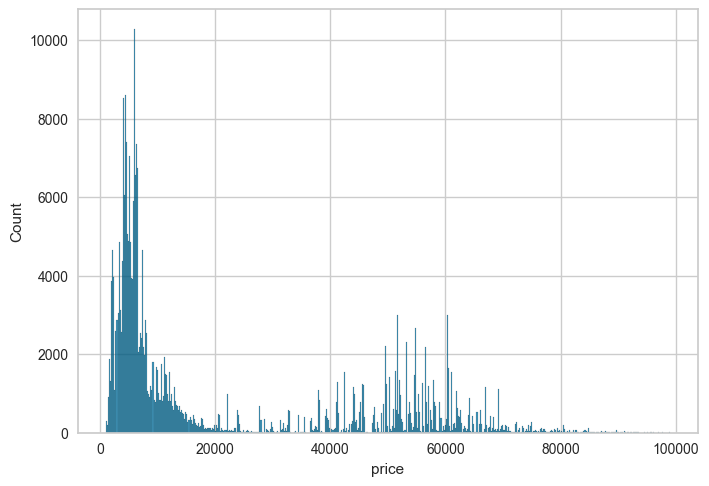

In [50]:
#square-root rule
sns.histplot(data=df, x='price', bins=round(np.sqrt(df.shape[0])))

<AxesSubplot: xlabel='price', ylabel='Count'>

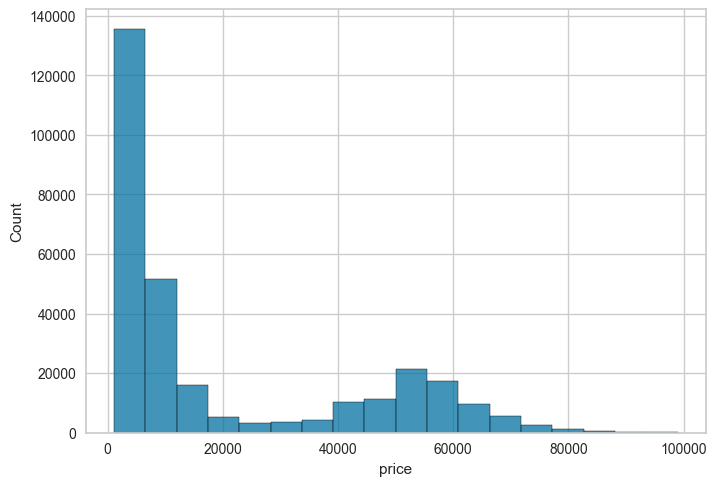

In [51]:
#Sturges' rule

sns.histplot(data=df, x='price', bins=round(log2(df.shape[0])))

<AxesSubplot: xlabel='price', ylabel='Count'>

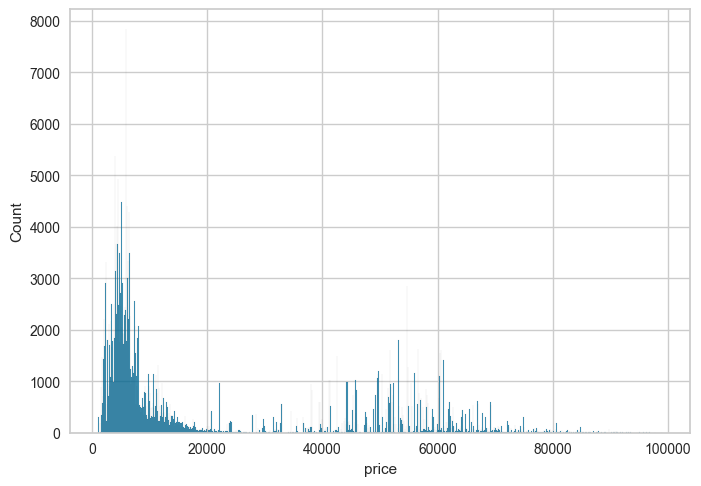

In [52]:
#Freedman-Diaconis' rule

#we removed some observatioms, so we have to calculate again the IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

sns.histplot(data=df, x='price', bins=round((2*IQR)/(df.shape[0]**(1/3))))

<AxesSubplot: xlabel='price', ylabel='Count'>

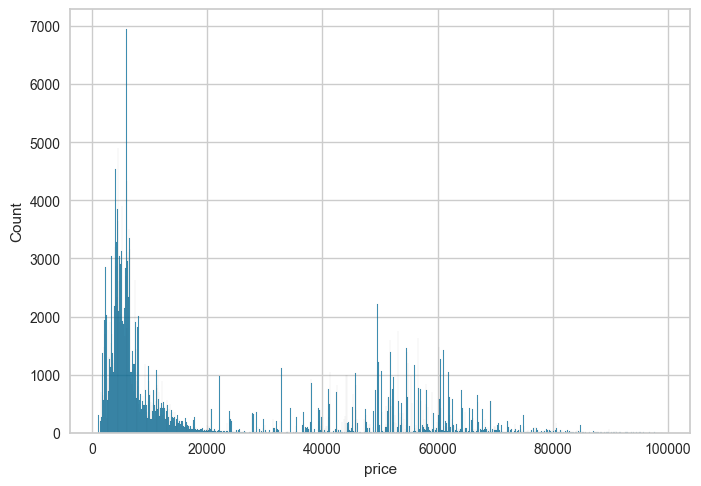

In [53]:
#Scott's rule
sns.histplot(data=df, x='price', bins=round((3.5*np.std(df['price']))/(df.shape[0]**(1/3))))

Sturges' rule seems to make not many bins and not to few bins

In [54]:
# create bins for the target variable
bins = pd.qcut(df['price'], q=round(log2(df.shape[0])), labels=False)

# create a stratified train-test split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2) #, random_state=42
for train_index, test_index in split.split(df, bins):
    train = df.iloc[train_index]
    test = df.iloc[test_index]

In [55]:
X_train, y_train = train.drop("price", axis=1), train["price"].values.flatten()
X_test, y_test = test.drop("price", axis=1), test["price"].values.flatten()

In [56]:
#no observation was lost while splitiing train and test
X_train.shape[0]+X_test.shape[0] == df.shape[0]

True

In [57]:
#########
########

## COLUMN TRANSFORMER

In [58]:
# otherwiese the power transform won't accept the array
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [59]:
power = PowerTransformer(method='box-cox')
y_train = power.fit_transform(y_train)
y_test = power.transform(y_test)

In [60]:
ct = ColumnTransformer([
    ('hot', OneHotEncoder(drop='first'), ['airline', 'source_city', 'departure_time', 'arrival_time', 'destination_city', 'class']), 
    ('ord', OrdinalEncoder(categories=[['zero', 'one', 'two_or_more']]), ['stops']),
    ('pow', PowerTransformer(method='box-cox'), ['duration']),
    ('std', StandardScaler(), ['duration']),
    ('drop', 'drop', ['flight'])
], remainder='passthrough') #passthrough is not useful this time, I'm just used to use it and I think it's good practice
ct

ColumnTransformer(remainder='passthrough',
                  transformers=[('hot', OneHotEncoder(drop='first'),
                                 ['airline', 'source_city', 'departure_time',
                                  'arrival_time', 'destination_city',
                                  'class']),
                                ('ord',
                                 OrdinalEncoder(categories=[['zero', 'one',
                                                             'two_or_more']]),
                                 ['stops']),
                                ('pow', PowerTransformer(method='box-cox'),
                                 ['duration']),
                                ('std', StandardScaler(), ['duration']),
                                ('drop', 'drop', ['flight'])])

In [61]:
loo_pipe = Pipeline([
    ('loo', LeaveOneOutEncoder()),
    ('std', StandardScaler())
])

In [62]:
ctl = ColumnTransformer([
    ('loo', loo_pipe, ['airline', 'source_city', 'departure_time', 'arrival_time', 'destination_city', 'class']), 
    ('ord', OrdinalEncoder(categories=[['zero', 'one', 'two_or_more']]), ['stops']),
    ('pow', PowerTransformer(method='box-cox'), ['duration']),
    ('std', StandardScaler(), ['duration']),
    ('drop', 'drop', ['flight'])
], remainder='passthrough') #passthrough is not useful this time, I'm just used to use it and I think it's good practice
ctl

ColumnTransformer(remainder='passthrough',
                  transformers=[('loo',
                                 Pipeline(steps=[('loo', LeaveOneOutEncoder()),
                                                 ('std', StandardScaler())]),
                                 ['airline', 'source_city', 'departure_time',
                                  'arrival_time', 'destination_city',
                                  'class']),
                                ('ord',
                                 OrdinalEncoder(categories=[['zero', 'one',
                                                             'two_or_more']]),
                                 ['stops']),
                                ('pow', PowerTransformer(method='box-cox'),
                                 ['duration']),
                                ('std', StandardScaler(), ['duration']),
                                ('drop', 'drop', ['flight'])])

In [63]:
########
########

# MODEL 1 - LINEAR MODEL

## LINEAR REGRESSION

In [64]:
from sklearn.linear_model import LinearRegression

In [65]:
model = LinearRegression()
pipe = Pipeline([
    ('column_transformer', ct),
    ('regressor', model)
])
pipe

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['airline', 'source_city',
                                                   'departure_time',
                                                   'arrival_time',
                                                   'destination_city',
                                                   'class']),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['zero',
                                                                              'one',
                                                                              'two_or_more']]),
                                                  ['stops']),
                                                 ('pow',
                                                  PowerTransformer(method='box-cox'),
                                                  ['duration']),
                                                 ('std', StandardScaler(),
                                                  ['duration']),
                                                 ('drop', 'drop',
                                                  ['flight'])])),
                ('regressor', LinearRegression())])

In [66]:
param_grid = {
    'regressor__fit_intercept': [True, False]
}

adesso = datetime.datetime.now()
###
#scoring = ['accuracy','recall']
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    verbose=3, #quando usiamo il parallel computer (n_jobs) il verbose non funziona
    #n_jobs=-1, #usa tutti i kernel 
    #pre_dispatch=4,
    #scoring=scoring
)

model_grid = grid.fit(X_train, y_train)
###
adesso_2 = datetime.datetime.now()
tempo_elapsed = adesso_2 - adesso
tempo_elapsed

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END .....regressor__fit_intercept=True;, score=0.881 total time=   0.9s
[CV 2/5] END .....regressor__fit_intercept=True;, score=0.882 total time=   0.8s
[CV 3/5] END .....regressor__fit_intercept=True;, score=0.883 total time=   0.9s
[CV 4/5] END .....regressor__fit_intercept=True;, score=0.883 total time=   0.9s
[CV 5/5] END .....regressor__fit_intercept=True;, score=0.882 total time=   0.9s
[CV 1/5] END ....regressor__fit_intercept=False;, score=0.872 total time=   0.9s
[CV 2/5] END ....regressor__fit_intercept=False;, score=0.873 total time=   0.9s
[CV 3/5] END ....regressor__fit_intercept=False;, score=0.874 total time=   0.9s
[CV 4/5] END ....regressor__fit_intercept=False;, score=0.874 total time=   0.9s
[CV 5/5] END ....regressor__fit_intercept=False;, score=0.874 total time=   0.8s


datetime.timedelta(seconds=9, microseconds=786368)

In [67]:
model_grid.best_params_

{'regressor__fit_intercept': True}

In [68]:
model = model_grid.best_estimator_
metrics()

R2:
train 0.8822213681800457
test: 0.8818033088321073


RMSE
train 0.3431889156426155
test: 0.3435373725302181


R2:
train 1.6601704666310837
test: 1.6325063846017036




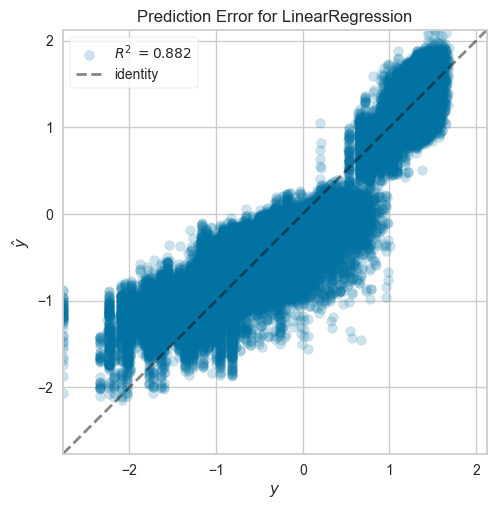

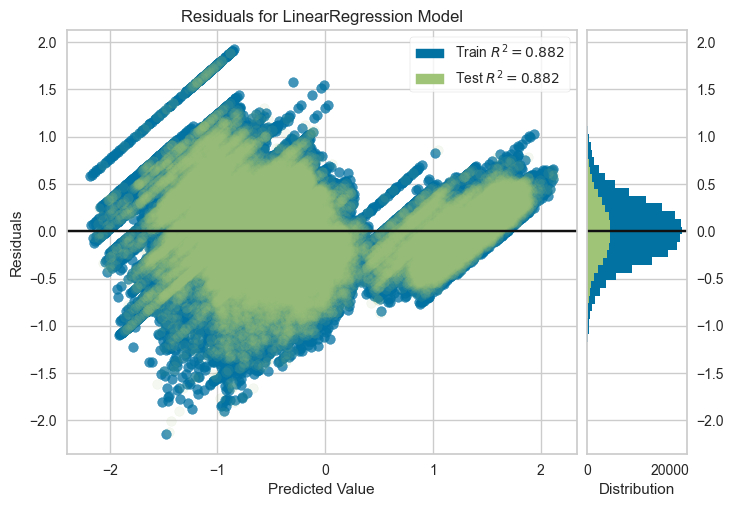

In [69]:
visualizer()

lets try with leave one out instead of one hot encoder

In [70]:
model = LinearRegression()
pipel = Pipeline([
    ('column_transformer', ctl),
    ('regressor', model)
])
pipel

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('loo',
                                                  Pipeline(steps=[('loo',
                                                                   LeaveOneOutEncoder()),
                                                                  ('std',
                                                                   StandardScaler())]),
                                                  ['airline', 'source_city',
                                                   'departure_time',
                                                   'arrival_time',
                                                   'destination_city',
                                                   'class']),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['zero',
                                                                              'one',
                                                                              'two_or_more']]),
                                                  ['stops']),
                                                 ('pow',
                                                  PowerTransformer(method='box-cox'),
                                                  ['duration']),
                                                 ('std', StandardScaler(),
                                                  ['duration']),
                                                 ('drop', 'drop',
                                                  ['flight'])])),
                ('regressor', LinearRegression())])

In [71]:
param_grid = {
    'regressor__fit_intercept': [True, False]
}

adesso = datetime.datetime.now()
###
#scoring = ['accuracy','recall']
grid = GridSearchCV(
    estimator=pipel,
    param_grid=param_grid,
    cv=5,
    verbose=3, #quando usiamo il parallel computer (n_jobs) il verbose non funziona
    #n_jobs=-1, #usa tutti i kernel 
    #pre_dispatch=4,
    #scoring=scoring
)

model_grid = grid.fit(X_train, y_train)
###
adesso_2 = datetime.datetime.now()
tempo_elapsed = adesso_2 - adesso
tempo_elapsed

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END .....regressor__fit_intercept=True;, score=0.870 total time=   1.1s
[CV 2/5] END .....regressor__fit_intercept=True;, score=0.872 total time=   1.1s
[CV 3/5] END .....regressor__fit_intercept=True;, score=0.873 total time=   1.2s
[CV 4/5] END .....regressor__fit_intercept=True;, score=0.872 total time=   1.1s
[CV 5/5] END .....regressor__fit_intercept=True;, score=0.872 total time=   1.1s
[CV 1/5] END ....regressor__fit_intercept=False;, score=0.868 total time=   1.0s
[CV 2/5] END ....regressor__fit_intercept=False;, score=0.870 total time=   1.1s
[CV 3/5] END ....regressor__fit_intercept=False;, score=0.870 total time=   1.1s
[CV 4/5] END ....regressor__fit_intercept=False;, score=0.870 total time=   1.1s
[CV 5/5] END ....regressor__fit_intercept=False;, score=0.870 total time=   1.1s


datetime.timedelta(seconds=12, microseconds=467274)

In [72]:
model_grid.best_params_

{'regressor__fit_intercept': True}

In [73]:
model = model_grid.best_estimator_
metrics()

R2:
train 0.871788202121926
test: 0.8710493643868489


RMSE
train 0.35806675058998993
test: 0.35882531422058084


R2:
train 1.711911860307691
test: 1.655167383288629




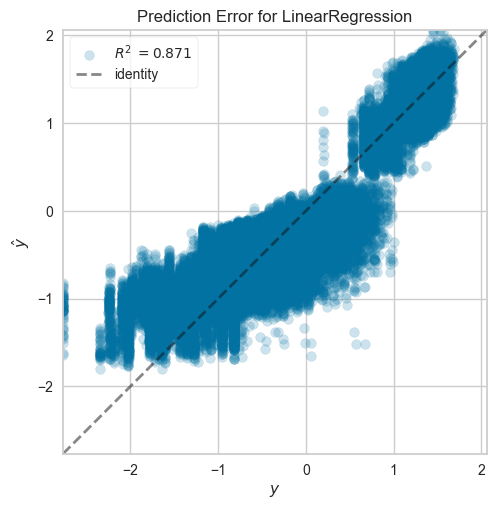

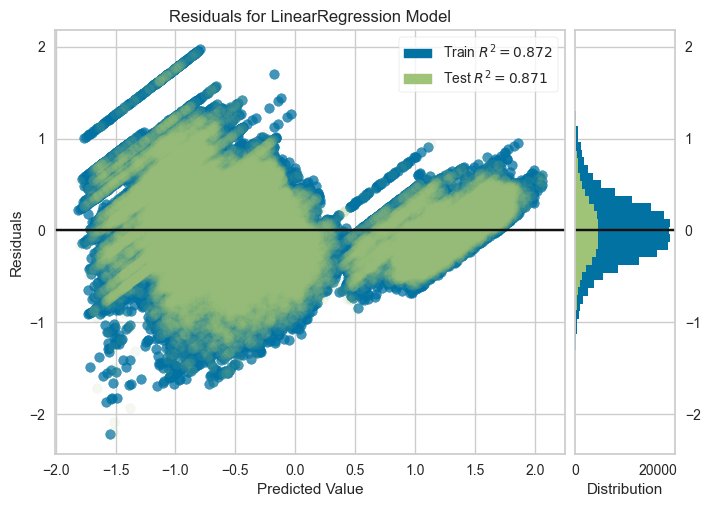

In [74]:
visualizer()

In [76]:
#provare polinomial features